I decided to try messing with the heat equation in my exploration of using ML to solve PDEs (and take a break from the Poisson equation). The equation itself is simple, as are the architectures I use to solve the equation, but this experiment proved interesting nonetheless. In particular, I found that the accuracy of the solution had more to do with the number and quality of the features I included for input than the architecture itself. I'll elaborate upon what I mean below. 

## Heat Equation
I was motivated to solve the heat equation partially because of the nice visualizations that arise from a solution. I include an animation at the end of each solution I describe below. Unfortunately it can only run if the cell is executed; I'm having some environmental issues generating animations that play in-browser that I'll troubleshoot later. Here's the rendition of the heat equation I consider:

$$
\begin{alignat*}{2}
& u_t(x,y,t)=\Delta_{(x,y)} u(x,y,t) && (x,y)\in B_1(0), t>0\\
& u(x,y,t)=0 && (x,y)\in\partial B_1(0), t\geq 0\\
& u(x,y,0)=\exp\left(-\frac{1}{1-(x^2+y^2)}\right) && (x,y)\in B_1(0)
\end{alignat*}
$$

for $B_1(0)\subset\mathbb{R}^2$. The bump function makes for a particularly nice set of solutions to illustrate. The solution decays quickly, so we will only simulate it for a small period of time. 

### Simple Neural Network Solution

First, I will use a simple neural network with a single hidden layer. It doesn't need to be very wide to get pretty good convergence to the solution. Here's the architecture I use:

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import display, clear_output

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(3, 8),
            nn.Sigmoid(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.sequential_model(x)

Below is my data sampler function, simililar to the data sampler I used in my post on the Poisson equation. I sample 10000 points in my example and proceed to solve the equation for $t\in\left[0,0.09\right]$. 

In [3]:
def SampleFromUnitBall(points):
    d = torch.distributions.Uniform(-1,1)
    d_t = torch.distributions.Uniform(0,0.1)

    x = torch.Tensor(points,1)
    y = torch.Tensor(points,1)
    t = torch.Tensor(points,1)
    j=0
    k=0

    while j<points:
        x_temp = d.sample()
        y_temp = d.sample()
        t_temp = d_t.sample()
        if x_temp**2+y_temp**2<1 and t_temp!=0:
            x[j,0]=x_temp
            y[j,0]=y_temp
            t[j,0]=k*1/(10*points)
            j+=1
            if j%1000==0 and j!=0:
                k+=1000

    xbdry = torch.Tensor(points,1)
    ybdry = torch.Tensor(points,1)
    tbdry = torch.zeros(x.size(0)).unsqueeze(1)
    j=0
    
    while j<points:
        x_temp = d.sample()
        xbdry[j,0]=x_temp
        if j%2==0:
            ybdry[j,0]=math.sqrt(1-x_temp**2)
        else:
            ybdry[j,0]=-math.sqrt(1-x_temp**2)
        j+=1

    return x, y, t, xbdry, ybdry, tbdry

In [22]:
x, y, t, xbdry, ybdry, tbdry = SampleFromUnitBall(10000)

The loss function is very similar to what we used in our Poisson solver. Again, I use a discrete mean-squared error function to compute the loss. In this case, I want to minimize the following,

$$L(x_{\text{int}},y_\text{int}, x_{\text{bdry}},y_{\text{bdry}}, t_{>0}):=\frac{1}{N_{\text{int}}}\sum_{j=1}^{N_{\text{int}}}|\Delta u(x^{(j)}_{\text{int}},y^{(j)}_{\text{int}}, t^{(j)}_{>0})-u(x^{(j)}_{\text{int}},y^{(j)}_{\text{int}}, t^{(j)}_{>0})|^2
$$
$$
+\frac{1}{N_{\text{bdry}}}\sum_{j=1}^{N_{\text{bdry}}}|u(x^{(j)}_{\text{bdry}},y^{(j)}_{\text{bdry}},t^{(j)}_{>0})|^2+\frac{1}{N_{\text{int}}}\sum_{j=1}^{N_{\text{int}}}|u(x^{(j)}_{\text{int}},y^{(j)}_{\text{int}},0)-g(x^{(j)}_{\text{int}},y^{(j)}_{\text{int}})|^2
$$

where $g(x,y):=\exp\left(-\frac{1}{1-(x^2+y^2)}\right)$.

To implement this loss function, I use the following code:

In [4]:
def g(x,y):
    return torch.exp(-1/(1-(x**2+y**2)))

In [24]:
def loss(x, y, t, xbdry, ybdry, tbdry, network):
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True
    temp_input = torch.cat((x,y,t),1)
    w=network(temp_input)
    temp_input_init = torch.cat((x,y,tbdry),1)
    w_init = network(temp_input_init)
    wbdry = network(torch.cat((xbdry, ybdry, t),1))

    dw_dx = torch.autograd.grad(w.sum(), x, create_graph = True)[0]
    ddw_ddx = torch.autograd.grad(dw_dx.sum(), x, create_graph = True)[0]
    dw_dy = torch.autograd.grad(w.sum(), y, create_graph = True)[0] 
    ddw_ddy = torch.autograd.grad(dw_dy.sum(), y, create_graph = True)[0]
    dw_dt = torch.autograd.grad(w.sum(), t, create_graph = True)[0] 

    A = torch.mean((dw_dt - (ddw_ddx+ddw_ddy))**2)
    B = torch.mean((w_init-g(x,y))**2)
    C = torch.mean((wbdry)**2)

    return A+B+C

Now I train the network. I use 100000 epochs to get pretty good convergence. 

In [25]:
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)

In [26]:
epochs = 100000
loss_values = np.zeros(100000)
for i in range(epochs):
    l = loss(x, y, t, xbdry, ybdry, tbdry, model)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_values[i]=l
    if i%1000==0:
        print("Loss at epoch {}: {}".format(i, l.item()))

Loss at epoch 0: 0.2738669812679291
Loss at epoch 1000: 0.025970257818698883
Loss at epoch 2000: 0.02568979375064373
Loss at epoch 3000: 0.025230783969163895
Loss at epoch 4000: 0.024398991838097572
Loss at epoch 5000: 0.022912777960300446
Loss at epoch 6000: 0.02087295800447464
Loss at epoch 7000: 0.018625637516379356
Loss at epoch 8000: 0.015907008200883865
Loss at epoch 9000: 0.013540136627852917
Loss at epoch 10000: 0.012002145871520042
Loss at epoch 11000: 0.010946547612547874
Loss at epoch 12000: 0.01010743249207735
Loss at epoch 13000: 0.0094174575060606
Loss at epoch 14000: 0.008831574581563473
Loss at epoch 15000: 0.008312895894050598
Loss at epoch 16000: 0.007835050113499165
Loss at epoch 17000: 0.0073796845972537994
Loss at epoch 18000: 0.00693441741168499
Loss at epoch 19000: 0.006492464803159237
Loss at epoch 20000: 0.006053541321307421
Loss at epoch 21000: 0.0056252810172736645
Loss at epoch 22000: 0.0052236150950193405
Loss at epoch 23000: 0.004869983531534672
Loss at ep

Evidently, one doesn't need many input features, nor does one need a very wide network to get pretty good convergence. Moreover, I demonstrate the heat flow in the unit circle using the following plots and animation. Here, I've plotted a few instances of the solution over test data and three points in time in $\left[0,0.09\right]$. Brighter colored scatter points indicate a higher value for $u(x,y,t)$. As expected, the maximum value for $u(x,y,t)$ decreases as time progresses, and the heat diffuses to be nearly constant. 

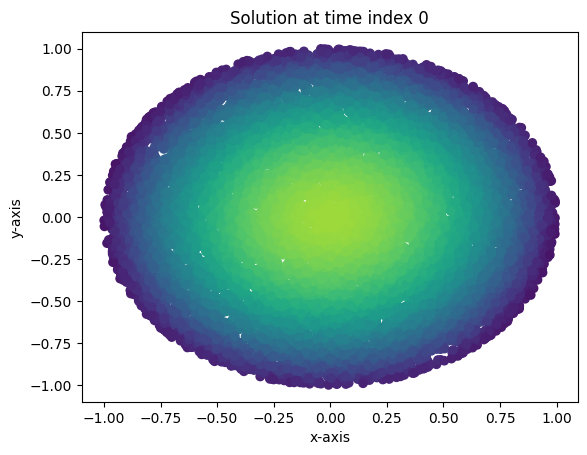

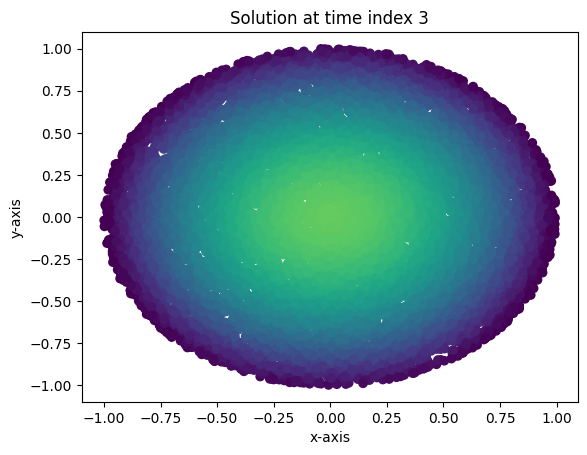

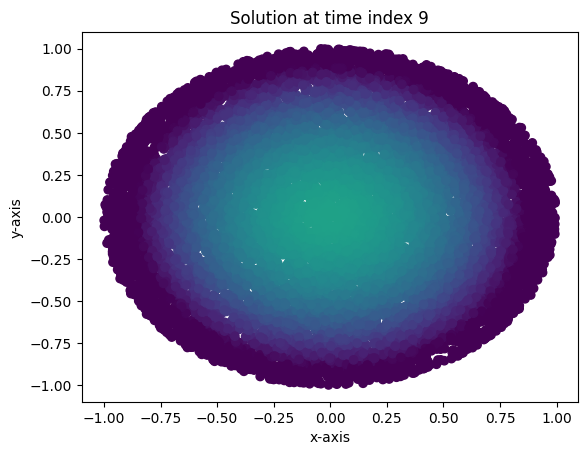

In [44]:
x_test, y_test, z_test, xbdry_test, ybdry_test, zbdry_test = SampleFromUnitBall(10000)

def plot_points(time_index):
    with torch.no_grad():
        temp_input = torch.cat((x_test,y_test,torch.ones(10000).unsqueeze(1)*time_index/100),1)
        soln=model(temp_input)
    plt.scatter(x=x_test.detach(),y=y_test.detach(),c=soln.detach(), vmin=0, vmax=0.35)
    plt.title("Solution at time index " + str(time_index))
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.show()

plot_points(0)
plot_points(3)
plot_points(9)

Running the cell below generates an animation of the solutions over time. I can even project the solutions past $t=0.09$ to show that the heat diffusion is accurately captured past our sample times. 

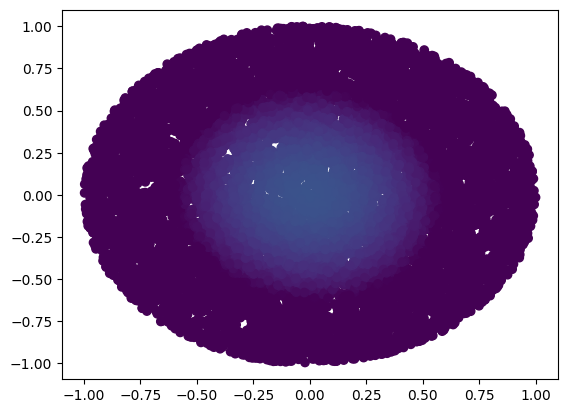

In [56]:
x_test, y_test, z_test, xbdry_test, ybdry_test, zbdry_test = SampleFromUnitBall(10000)
fig, ax = plt.subplots()
for k in range(20):
    with torch.no_grad():
        temp_input = torch.cat((x_test,y_test,torch.ones(10000).unsqueeze(1)*k/100),1)
        soln=model(temp_input)
    ax.cla()
    ax.scatter(x=x_test.detach(),y=y_test.detach(),c=soln.detach(), vmin=0, vmax=0.35)
    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)

### Polynomial regression solution

Now, I sample a new set of points and construct a "neural network" which actually allows me to run polynomial regression using my loss function. I show that a degree four polynomial in the input features is suitable for an accurate approximation to a solution of the problem. Here, I take advantage of the fact that the initial condition is radial in its input and admits a nice Taylor expansion in the radial coordinate $r^2=x^2+y^2$. Hence, an accurate approximation of the initial condition may be obtained by using a low-degree polynomial. Interestingly, even though the Taylor series only contains even powers of $r$, including all odd degree terms seemed to improve convergence. Furthermore, the polynomial approximation converges much more rapidly to the actual solution than the nueral network. Essentially, the polynomial approximation contains far more "useful" features than the simple coordinate and time input features I used in the neural network input. 

In [5]:
x, y, t, xbdry, ybdry, tbdry = SampleFromUnitBall(10000)

In [6]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.sequential_model(x)

The loss function is really ugly since I need to compute all polynomial features and their derivatives, so I've left the loss function collapsed. I wanted to use scikit-learn's polynomial feature class, but this destroyed the derivative data in my tensors, so I'd have to create a polynomial feature class from scratch. I might do this in the future, but for now everything is hardcoded. 

In [7]:
def loss2(x, y, t, xbdry, ybdry, tbdry, network):
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True

    #Here come all of the polynomial features....

    x_2 = x**2
    y_2 = y**2
    x_3 = x**3
    y_3 = y**3
    x_4 = x**4
    y_4 = y**4
    xy_2 = x*(y**2)
    x_2y = (x**2)*y
    xyt = x*y*t
    x_2t = (x**2)*t
    y_2t = (y**2)*t
    t_3 = t**3
    t_4 = t**4
    x_3y = (x**3)*y
    xy_3 = x*(y**3)
    x_2y_2 = (x**2)*(y**2)
    x_3t = (x**3)*t
    x_2t_2 = (x**2)*(t**2)
    xt_3 = x*(t**3)
    y_3t = (y**3)*t
    y_2t_2 = (y**2)*(t**2)
    yt_3 = y*(t**3)
    xyt_2 = x*y*(t**2)
    xy_2t = x*(y**2)*t
    x_2yt = (x**2)*y*t
    xy = x*y
    t_2 = t**2
    xt = x*t
    yt = y*t
    xbdry_2 = xbdry**2
    ybdry_2 = ybdry**2
    xbdry_3 = xbdry**3
    ybdry_3 = ybdry**3
    xbdry_4 = xbdry**4
    ybdry_4 = ybdry**4
    xbdryybdry_2 = xbdry*(ybdry**2)
    xbdry_2ybdry = (xbdry**2)*ybdry
    xbdryybdryt = xbdry*ybdry*t
    xbdry_2t = (xbdry**2)*t
    ybdry_2t = (ybdry**2)*t
    xbdry_ybdry = xbdry*ybdry
    tbdry_2 = tbdry**2
    xbdry_t= xbdry*t
    ybdry_t = ybdry*t
    x_tbdry = x*tbdry
    y_tbdry = y*tbdry
    xytbdry = x*y*tbdry
    x_2tbdry = (x**2)*tbdry
    y_2tbdry = (y**2)*tbdry
    tbdry_3 = tbdry**3
    tbdry_4 = tbdry**4
    xbdry_3ybdry = (xbdry**3)*ybdry
    xbdryybdry_3 = xbdry*(ybdry**3)
    xbdry_2ybdry_2 = (xbdry**2)*(ybdry**2)
    xbdry_3t = (xbdry**3)*t
    xbdry_2t_2 = (xbdry**2)*(t**2)
    xbdryt_3 = xbdry*(t**3)
    ybdry_3t = (ybdry**3)*t
    ybdry_2t_2 = (ybdry**2)*(t**2)
    ybdryt_3 = ybdry*(t**3)
    x_3tbdry = (x**3)*tbdry
    x_2tbdry_2 = (x**2)*(tbdry**2)
    xtbdry_3 = x*(tbdry**3)
    y_3tbdry = (y**3)*tbdry
    y_2tbdry_2 = (y**2)*(tbdry**2)
    ytbdry_3 = y*(tbdry**3)
    xbdryybdryt_2 = xbdry*ybdry*(t**2)
    xbdryybdry_2t = xbdry*(ybdry**2)*t
    xbdry_2ybdryt = (xbdry**2)*ybdry*t  
    xytbdry_2 = x*y*(tbdry**2)
    xy_2tbdry = x*(y**2)*tbdry
    x_2ytbdry = (x**2)*y*tbdry

    ##End of polynomial features

    temp_input = torch.cat((x,y,t,x_2,y_2,xy,t_2,xt,yt,x_4,y_4,t_4,x_3y,xy_3,x_2y_2,x_3t,x_2t_2,xt_3,y_3t,y_2t_2,yt_3,xyt_2,xy_2t,x_2yt,x_3,y_3,xy_2,x_2y,xyt,x_2t,y_2t,t_3),1)
    w=network(temp_input)
    temp_input_init = torch.cat((x,y,tbdry,x_2,y_2,xy,tbdry_2,x_tbdry,y_tbdry,x_4,y_4,tbdry_4,x_3y,xy_3,x_2y_2,x_3tbdry,x_2tbdry_2,xtbdry_3,y_3tbdry,y_2tbdry_2,ytbdry_3,xytbdry_2,xy_2tbdry,x_2ytbdry,x_3,y_3,xy_2,x_2y,xytbdry,x_2tbdry,y_2tbdry,tbdry_3),1)
    w_init = network(temp_input_init)
    wbdry = network(torch.cat((xbdry, ybdry, t,xbdry_2,ybdry_2,xbdry_ybdry,t_2,xbdry_t,ybdry_t,xbdry_4,ybdry_4,t_4,xbdry_3ybdry,xbdryybdry_3,xbdry_2ybdry_2,xbdry_3t,xbdry_2t_2,xbdryt_3,ybdry_3t,ybdry_2t_2,ybdryt_3,xbdryybdryt_2,xbdryybdry_2t,xbdry_2ybdryt,xbdry_3,ybdry_3,xbdryybdry_2,xbdry_2ybdry,xbdryybdryt,xbdry_2t,ybdry_2t,t_3),1))

    dw_dx = torch.autograd.grad(w.sum(), x, create_graph = True)[0]
    ddw_ddx = torch.autograd.grad(dw_dx.sum(), x, create_graph = True)[0]
    dw_dy = torch.autograd.grad(w.sum(), y, create_graph = True)[0] 
    ddw_ddy = torch.autograd.grad(dw_dy.sum(), y, create_graph = True)[0]
    dw_dt = torch.autograd.grad(w.sum(), t, create_graph = True)[0] 

    A = torch.mean((dw_dt - (ddw_ddx+ddw_ddy))**2)
    B = torch.mean((w_init-g(x,y))**2)
    C = torch.mean((wbdry)**2)
    #print("Loss for each item: {}, {}, {}".format(A,B,C))
    return A+B+C

Below, I define a helper function for computing values the network generates from input data. It computes all of the needed polynomial features before supplying them into the network. 

In [8]:
def network_value(x, y, t, network):
    x_2 = x**2
    y_2 = y**2
    x_3 = x**3
    y_3 = y**3
    x_4 = x**4
    y_4 = y**4
    xy_2 = x*(y**2)
    x_2y = (x**2)*y
    xyt = x*y*t
    x_2t = (x**2)*t
    y_2t = (y**2)*t
    t_3 = t**3
    t_4 = t**4
    xy = x*y
    t_2 = t**2
    xt = x*t
    yt = y*t
    x_3y = (x**3)*y
    xy_3 = x*(y**3)
    x_2y_2 = (x**2)*(y**2)
    x_3t = (x**3)*t
    x_2t_2 = (x**2)*(t**2)
    xt_3 = x*(t**3)
    y_3t = (y**3)*t
    y_2t_2 = (y**2)*(t**2)
    yt_3 = y*(t**3)
    xyt_2 = x*y*(t**2)
    xy_2t = x*(y**2)*t
    x_2yt = (x**2)*y*t
    temp_input = torch.cat((x,y,t,x_2,y_2,xy,t_2,xt,yt,x_4,y_4,t_4,x_3y,xy_3,x_2y_2,x_3t,x_2t_2,xt_3,y_3t,y_2t_2,yt_3,xyt_2,xy_2t,x_2yt,x_3,y_3,xy_2,x_2y,xyt,x_2t,y_2t,t_3),1)
    w=network(temp_input)
    return w

Now, I build and train the network. 

In [9]:
model2 = NeuralNetwork2()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=.9)

In [10]:
epochs = 100000
loss_values = np.zeros(100000)
for i in range(epochs):
    l = loss2(x, y, t, xbdry, ybdry, tbdry, model2)
    l.backward()
    optimizer2.step()
    optimizer2.zero_grad()
    loss_values[i]=l
    if i%1000==0:
        print("Loss at epoch {}: {}".format(i, l.item()))

Loss at epoch 0: 0.89188551902771
Loss at epoch 1000: 0.003854417707771063
Loss at epoch 2000: 0.0035820240154862404
Loss at epoch 3000: 0.003396423067897558
Loss at epoch 4000: 0.0032313335686922073
Loss at epoch 5000: 0.003081361996009946
Loss at epoch 6000: 0.0029437472112476826
Loss at epoch 7000: 0.0028166514821350574
Loss at epoch 8000: 0.0026987330056726933
Loss at epoch 9000: 0.002588952425867319
Loss at epoch 10000: 0.002486460143700242
Loss at epoch 11000: 0.0023905490525066853
Loss at epoch 12000: 0.0023006070405244827
Loss at epoch 13000: 0.0022161088418215513
Loss at epoch 14000: 0.002136589726433158
Loss at epoch 15000: 0.0020616455003619194
Loss at epoch 16000: 0.0019909129478037357
Loss at epoch 17000: 0.001924069132655859
Loss at epoch 18000: 0.0018608317477628589
Loss at epoch 19000: 0.0018009372288361192
Loss at epoch 20000: 0.0017441592644900084
Loss at epoch 21000: 0.001690280856564641
Loss at epoch 22000: 0.0016391162062063813
Loss at epoch 23000: 0.00159049092326

Evidently, the convergence to a solution is much more rapid (one needs far fewer epochs to obtain the same loss as in the more traditional neural network). Below are plots of the solution, as well as an animation. These look virtually identical to the results using the more traditional neural network. 

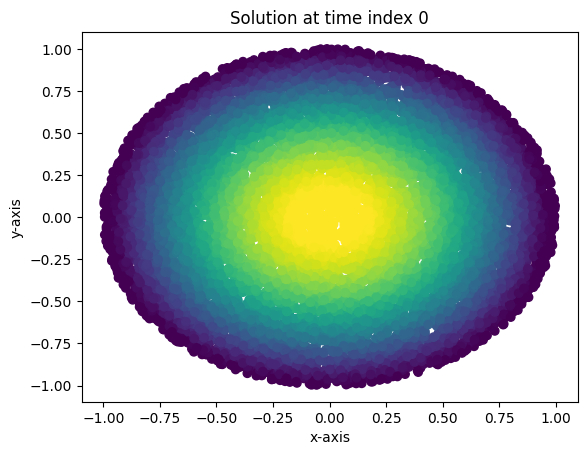

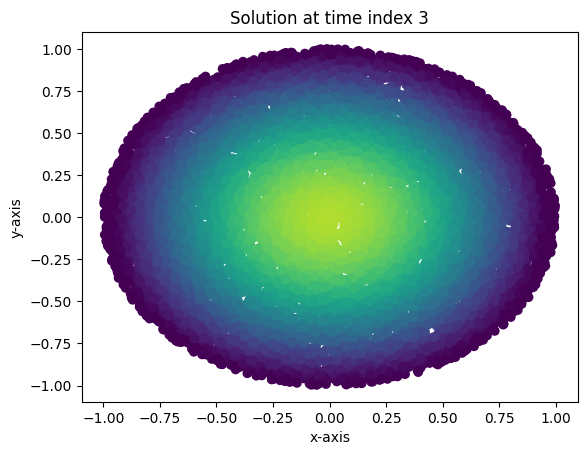

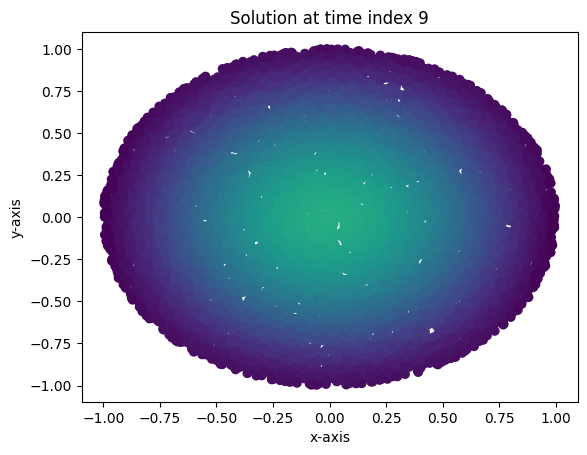

In [11]:
x_test, y_test, z_test, xbdry_test, ybdry_test, zbdry_test = SampleFromUnitBall(10000)

def plot_points2(time_index):
    with torch.no_grad():
        soln = network_value(x_test,y_test,torch.ones(10000).unsqueeze(1)*time_index/100,model2)
    plt.scatter(x=x_test.detach(),y=y_test.detach(),c=soln.detach(), vmin=0, vmax=0.35)
    plt.title("Solution at time index " + str(time_index))
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.show()

plot_points2(0)
plot_points2(3)
plot_points2(9)

Interestingly, projecting the solution into the future past $t=0.09$ seems to yield a less accurate solution than the one I got from the neural network. But still, this isn't bad and leads to some interesting theoretical questions as to the degree of polynomial required to get "future in time" predictions which are as accurate as the network. 

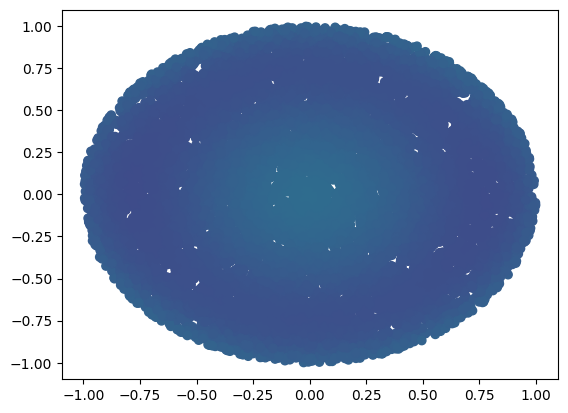

In [12]:
x_test, y_test, z_test, xbdry_test, ybdry_test, zbdry_test = SampleFromUnitBall(10000)
fig, ax = plt.subplots()
for k in range(20):
    with torch.no_grad():
        soln = network_value(x_test,y_test,torch.ones(10000).unsqueeze(1)*k/100,model2)
    ax.cla()
    ax.scatter(x=x_test.detach(),y=y_test.detach(),c=soln.detach(), vmin=0, vmax=0.35)
    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)

Now that I have all of this set up, it would be interesting to run the code against more complicated initial conditions. I leave this exercise to the reader. Next time, I think I'll get back to something more like the Poisson equation, or perhaps work on solving PDEs which arise from variational problems. Overall, solving PDEs using neural networks or polynomial regression is proving productive and interesting! 